In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpolate

In [2]:
# Файлы уже с данными только по России
b_history = pd.read_csv('edited_data/b_history.csv', sep=';', index_col='Year')
m_history = pd.read_csv('edited_data/m_history.csv', sep=';', index_col='Year')
f_history = pd.read_csv('edited_data/f_history.csv', sep=';', index_col='Year')
b_future = pd.read_csv('edited_data/b_future.csv', sep=';', index_col='Year')
m_future = pd.read_csv('edited_data/m_future.csv', sep=';', index_col='Year')
f_future = pd.read_csv('edited_data/f_future.csv', sep=';', index_col='Year')

In [3]:
# Предварительная подготовка данных
m_history_update = {year: [year, value] for year, value in zip(m_history.index[:-3], m_history['75 - 79'])}
f_history_update = {year: [year, value] for year, value in zip(f_history.index[:-3], f_history['75 - 79'])}
b_history_update = {year: [year, m_value + f_value, 0, 0, 0, 0, 0] for year, m_value, f_value in 
                    zip(m_history.index[:-3], m_history['75 - 79'], f_history['75 - 79'])}

for update_history, history in zip((m_history_update, f_history_update), (m_history, f_history)):

    probas = history.shift(-1).shift(-1, axis="columns").div(history). \
                     loc[2000][[str(i) + ' - ' + str(i + 4) for i in range(75, 96, 5)]]
    update_history[1950] = [1950, history.loc[1950]['75 - 79'], None, None, None, None, None]

    for year, prev_year in zip(list(update_history.keys())[1:], update_history.keys()):
        for i, proba in enumerate(probas):
            update_history[year].append(update_history[prev_year][i + 1] * proba) if update_history[prev_year][i + 1] \
                                 else update_history[year].append(None)
    
    for year, values in update_history.items():
        for i, value in enumerate(values[2:]):
            if value:
                b_history_update[year][i + 2] += value
            else:
                b_history_update[year][i + 2] = None

upd_columns = ['Year'] + [str(i) + ' - ' + str(i + 4) for i in range(75, 96, 5)] + ['100+']
m_history_update = pd.DataFrame.from_dict(m_history_update, orient='index', columns=upd_columns)
f_history_update = pd.DataFrame.from_dict(f_history_update, orient='index', columns=upd_columns)
b_history_update = pd.DataFrame.from_dict(b_history_update, orient='index', columns=upd_columns)
m_history.update(m_history_update)
f_history.update(f_history_update)
b_history.update(b_history_update)

In [4]:
m_survival_df = m_history.shift(-1).shift(-1, axis="columns").div(m_history)
f_survival_df = f_history.shift(-1).shift(-1, axis="columns").div(f_history)

m_year_survival = {year: {age.split(' - ')[1]: v for age, v in zip(m_survival_df.loc[year].dropna().index, m_survival_df.loc[year].dropna())} 
                  if year % 5 == 0 else {} for year in range(1950, 2001)}
f_year_survival = {year: {age.split(' - ')[1]: v for age, v in zip(f_survival_df.loc[year].dropna().index, f_survival_df.loc[year].dropna())} 
                  if year % 5 == 0 else {} for year in range(1950, 2001)}

m_age_survival = {age: {} for age in [str(i) for i in range(100)]}
f_age_survival = {age: {} for age in [str(i) for i in range(100)]}

for new_survival, new_age_survival in zip((m_year_survival, f_year_survival), (m_age_survival, f_age_survival)):
    for year, age_data in new_survival.items():
        if age_data:
            ages = [int(age) for age in age_data.keys()]
            
            new_survival[year] = {str(age): new_survival[year][str(age)] if age in ages else 1.
                                  for age in range(0, min(max(ages) + 3, 100))}
            
            for age in range(0, min(max(ages) + 3, 100)):
                new_age_survival[str(age)][year] = new_survival[year][str(age)]
    
    for age in new_age_survival.keys():
        years = list(new_age_survival[age].keys())
        numbers = list(new_age_survival[age].values())
        intp = interpolate.interp1d(years, numbers, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        
        for year in new_survival.keys():
            new_survival[year][age] = np.round(intp(year), 3) if min(years) <= year <= max(years) else None
    
    for year in new_survival.keys():
        new_survival[year] = [year] + list(new_survival[year].values())

m_survival_df = pd.DataFrame.from_dict(m_year_survival, orient='index', 
                                       columns=['Year'] + [str(i) for i in range(0, 100)])
f_survival_df = pd.DataFrame.from_dict(f_year_survival, orient='index', 
                                       columns=list(m_survival_df.columns))
m_survival_df.set_index('Year', inplace=True)
f_survival_df.set_index('Year', inplace=True)

In [5]:
# Интерполяция данных - сначала (из 0 - 4 получаем 0, 1, 2, 3, 4), 
# После - заполнение промежуточных годов (1956, 1957 и др.).
m_year_history = {year: {age: v for age, v in zip(m_history.loc[year].dropna().index, m_history.loc[year].dropna())} 
                  if year % 5 == 0 else {} for year in range(1950, 2006)}
f_year_history = {year: {age: v for age, v in zip(f_history.loc[year].dropna().index, f_history.loc[year].dropna())} 
                  if year % 5 == 0 else {} for year in range(1950, 2006)}

m_age_history = {age: {} for age in [str(i) for i in range(100)] + ['100+']}
f_age_history = {age: {} for age in [str(i) for i in range(100)] + ['100+']}

for new_history, new_age_history in zip((m_year_history, f_year_history), (m_age_history, f_age_history)):
    for year, age_data in new_history.items():  
        if age_data:
            ages = [0] + [int(age.split(' - ')[1]) + 1 if age != '100+' else 115 for age in age_data.keys()]
            numbers = [0.] + [sum(list(age_data.values())[:i + 1]) for i in range(len(age_data.values()))]
            ages = ages[:-1]
            numbers = numbers[:-1]
            intp = interpolate.interp1d(ages, numbers, bounds_error=False, fill_value="extrapolate", kind="cubic")

            new_history[year] = {str(age): round((intp(age + 1) - intp(age)), 3) 
                                 for age in range(min(ages), min(max(ages) + 1, 100))}
            
            for age in range(min(ages), min(max(ages) + 1, 100)):
                new_age_history[str(age)][year] = new_history[year][str(age)]
            
            if '-' not in list(age_data.keys())[-1]:
                new_history[year]['100+'] = list(age_data.values())[-1]
                new_age_history['100+'][year] = new_history[year]['100+']

            
for new_history, new_age_history in zip((m_year_history, f_year_history), (m_age_history, f_age_history)):
    for age in new_age_history.keys():
        years = list(new_age_history[age].keys())
        numbers = list(new_age_history[age].values())
        intp = interpolate.interp1d(years, numbers, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        
        for year in m_year_history.keys():
            new_history[year][age] = np.round(intp(year), 3) if min(years) <= year <= max(years) else None
    
    for year in new_history.keys():
        new_history[year] = [year] + list(new_history[year].values())

b_year_history = {year: [year] + [m_number + f_number if m_number else None for m_number, f_number in 
                                  zip(m_year_history[year][1:], f_year_history[year][1:])] 
                  for year in range(1950, 2006)}

# Запись в DataFrame.
m_history = pd.DataFrame.from_dict(m_year_history, orient='index', 
                                   columns=['Year'] + [str(i) for i in range(0, 100)] + ['100+'])
f_history = pd.DataFrame.from_dict(f_year_history, orient='index', 
                                   columns=list(m_history.columns))
b_history = pd.DataFrame.from_dict(b_year_history, orient='index', 
                                   columns=list(m_history.columns))
m_history.set_index('Year', inplace=True)
f_history.set_index('Year', inplace=True)
b_history.set_index('Year', inplace=True)

In [6]:
# Предсказание.
forecast_year = 2200

# Коэффициент фертильности.
fertility = b_history.take([0], axis=1).loc[2005, :][0] / \
            sum(f_history.loc[2005, [col for col in f_history.columns if '19' < col < '40 - 44']].values)
# Соотношение мальчиков, девочек.
m_ratio = m_history.take([0], axis=1).div(b_history.take([0], axis=1)).loc[2005, :][0]
f_ratio = f_history.take([0], axis=1).div(b_history.take([0], axis=1)).loc[2005, :][0]

# Коэффициенты выживаемости для всех возрастов.
m_survival = m_survival_df.loc[2000]
f_survival = f_survival_df.loc[2000]

m_forecast = {2005: {age: number for age, number in 
                     zip(m_survival.index, m_history.loc[2005, :].values)}}
f_forecast = {2005: {age: number for age, number in 
                     zip(m_survival.index, f_history.loc[2005, :].values)}}
b_forecast = {2005: {age: m_number + f_number for age, m_number, f_number in 
                     zip(m_survival.index, m_history.loc[2005, :].values, f_history.loc[2005, :].values)}}

for year in range(2006, forecast_year + 1):
    
    m_forecast[year] = {m_survival.index[0]: m_ratio * fertility * 
                        sum([v for k, v in f_forecast[year - 1].items() if '19' < k < '40 - 44'])}
    f_forecast[year] = {f_survival.index[0]: f_ratio * fertility * 
                        sum([v for k, v in f_forecast[year - 1].items() if '19' < k < '40 - 44'])}
    
    for age, prev_age in zip(m_survival.index[1:], m_survival.index):
        m_forecast[year][age] = m_forecast[year - 1][prev_age] * m_survival[prev_age]
        f_forecast[year][age] = f_forecast[year - 1][prev_age] * f_survival[prev_age]
    
    b_forecast[year] = {age: m_number + f_number for age, m_number, f_number in 
                        zip(m_survival.index, m_forecast[year].values(), f_forecast[year].values())}

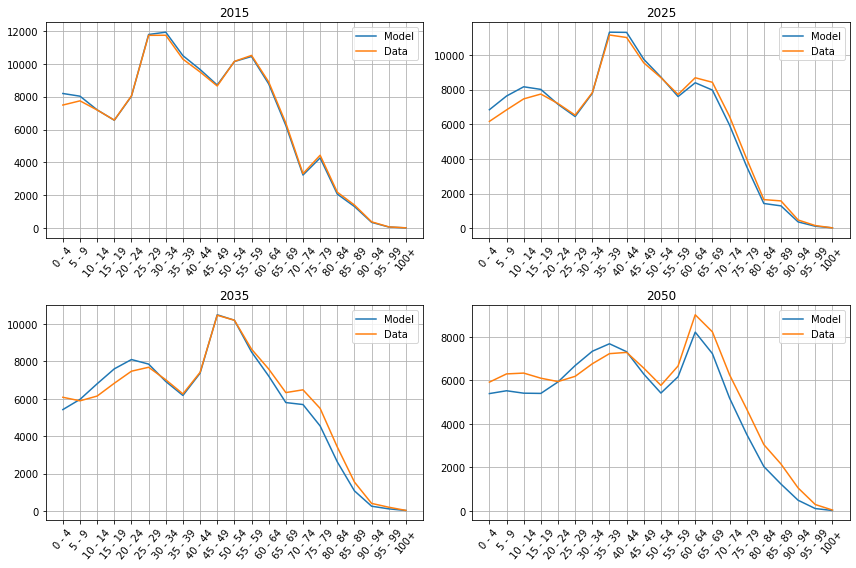

In [7]:
# Сравнение с общими(both) данными из исходных данных
fig, axs = plt.subplots(2, 2, figsize=(12,8))

for (i, j), year in zip([(0, 0), (0, 1), (1, 0), (1, 1)], [2015, 2025, 2035, 2050]):
    ages = [str(i) + ' - ' + str(i + 4) for i in range(0, 100, 5)] + ['100+']
    numbers = list(b_forecast[year].values())
    axs[i][j].plot(ages, [sum(numbers[i:i+5]) for i in range(0, 96, 5)] + [numbers[-1]], label='Model')
    axs[i][j].plot(ages, list(b_future.loc[year].values), label='Data')

for year, ax in zip([2015, 2025, 2035, 2050], axs.flat):
    ax.set(title=str(year))
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(50)

fig.tight_layout()

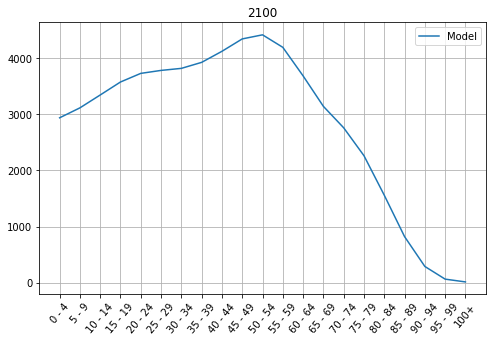

In [8]:
# Профиль через 100 лет.
year = 2100
plt.figure(figsize=(8, 5))
ages = [str(i) + ' - ' + str(i + 4) for i in range(0, 100, 5)] + ['100+']
numbers = list(b_forecast[year].values())
plt.plot(ages, [sum(numbers[i:i+5]) for i in range(0, 96, 5)] + [numbers[-1]], label='Model')
plt.title(str(2100))
plt.xticks(rotation=50)
plt.legend()
plt.grid()
plt.show()

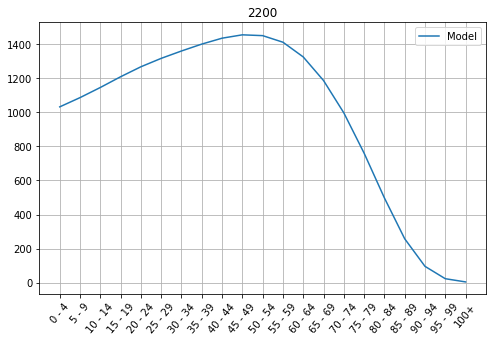

In [10]:
# Профиль через 200 лет.
year = 2200
plt.figure(figsize=(8, 5))
ages = [str(i) + ' - ' + str(i + 4) for i in range(0, 100, 5)] + ['100+']
numbers = list(b_forecast[year].values())
plt.plot(ages, [sum(numbers[i:i+5]) for i in range(0, 96, 5)] + [numbers[-1]], label='Model')
plt.title(str(2200))
plt.xticks(rotation=50)
plt.legend()
plt.grid()
plt.show()

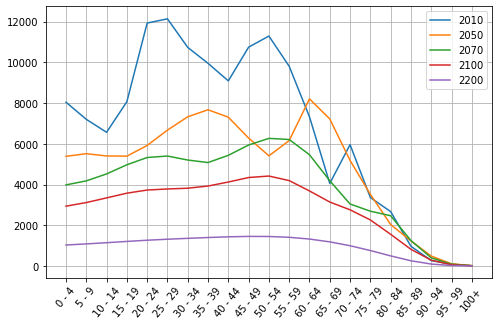

In [11]:
# Сравнение профилей для 2010, 2050, 2070, 2100 и 2200 годов
plt.figure(figsize=(8, 5))
ages = [str(i) + ' - ' + str(i + 4) for i in range(0, 100, 5)] + ['100+']
for year in [2010, 2050, 2070, 2100, 2200]:
    numbers = list(b_forecast[year].values())
    plt.plot(ages, [sum(numbers[i:i+5]) for i in range(0, 96, 5)] + [numbers[-1]], label=str(year))
plt.xticks(rotation=50)
plt.legend()
plt.grid()
plt.show()